# Test of "filter" and "filtfilt" Functions from Ardour

resource: https://github.com/djpohly/ardour/tree/master/libs/qm-dsp/dsp/signalconditioning

### Import Packages and load Data Set

In [7]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from scipy import signal

In [8]:
data_path = os.path.join( os.getcwd(), 'data', 'MATLAB_ECG_filtfilt_data.CSV')
df_matlab_results = pd.read_csv(data_path, sep=';')
df_matlab_results.head(11)

,wform,noise,wform_noisy,y_filtfilt,y_filter,filtACoeffs,filtBCoeffs
0,0.000000,0.053767,0.053767,0.053767,0.005377,1.0,0.1
1,0.000273,0.183389,0.183662,0.053885,0.023743,0.0,0.1
2,0.000547,-0.225885,-0.225338,0.051676,0.001209,0.0,0.1
3,0.000820,0.086217,0.087037,0.052207,0.009913,0.0,0.1
4,0.001093,0.031877,0.032970,0.051684,0.013210,0.0,0.1
5,0.001367,-0.130769,-0.129402,0.052746,0.000270,0.0,0.1
6,0.001640,-0.043359,-0.041719,0.058602,-0.003902,0.0,0.1
7,0.001914,0.034262,0.036176,0.065958,-0.000285,0.0,0.1
8,0.002187,0.357840,0.360027,0.074331,0.035718,0.0,0.1
9,0.002460,0.276944,0.279404,0.080291,0.063658,0.0,0.1


In [9]:
df_index = df_matlab_results.index
df_wform = df_matlab_results.wform.values.flatten()                 # base signal: ECG-Waveform without noise
df_wform_noisy = df_matlab_results.wform_noisy.values.flatten()     # input signal for analysis: ECG-Waveform with noise
df_matlab_filtfilt = df_matlab_results.y_filtfilt.values.flatten()  # MATLAB "filtfilt" function results for input signal
df_matlab_filter = df_matlab_results.y_filter.values.flatten()      # MATLAB "filter" function results for input signal

In [10]:
# define moving average filter with N = 10
filt_B_coeffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
filt_A_coeffs = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

filt_ord = max(len(filt_B_coeffs),len(filt_A_coeffs))-1  # filter order: 9

### Plot used Data 

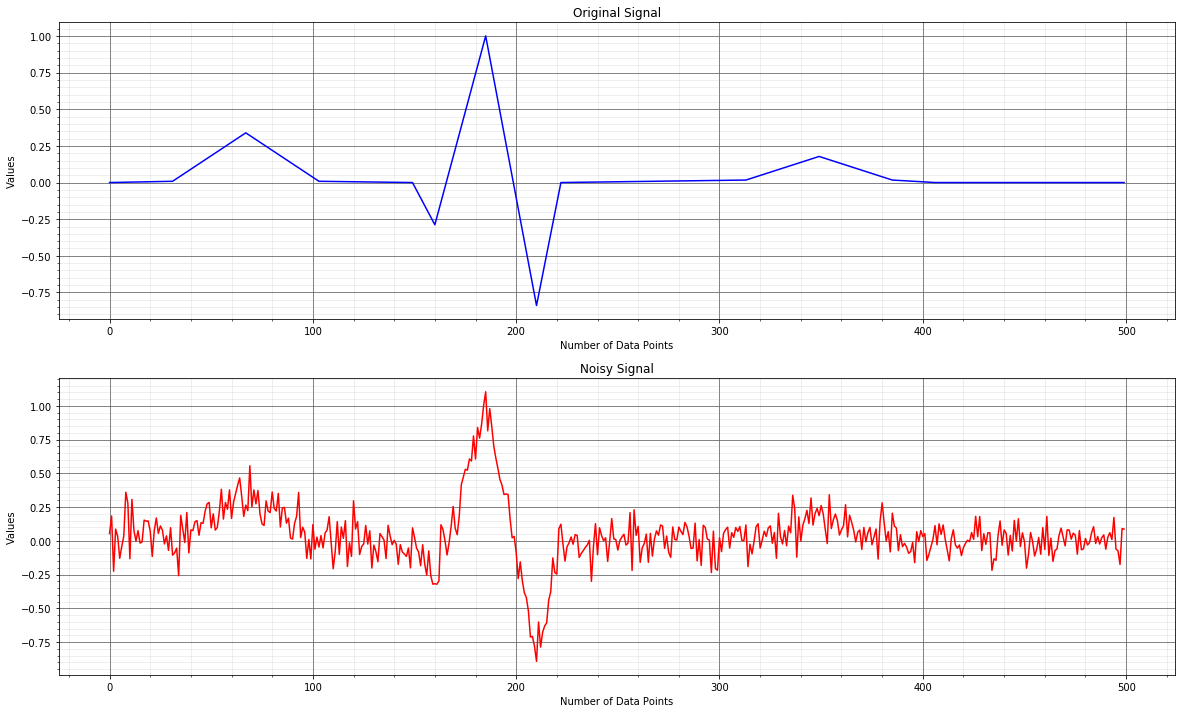

In [11]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,12))

ax0.plot(df_index, df_wform, color='blue', label ='orginal signal')
ax1.plot(df_index, df_wform_noisy, color='red', label ='noisy signal')

ax0.set_title('Original Signal')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Noisy Signal')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

## Ardour "filter" Function (conventional filter with phase-distortion)

In [12]:
def filterArdour(filt_ord, filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    u = input_signal                # input signal
    length = input_signal_len       # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))         # output signal; initialize with zeros
    
    inBuffer = np.zeros((filt_ord+1,))  # buffer for input signal with window length of (filter_ord+1) ; initialize with zeros
    outBuffer = np.zeros((filt_ord+1,)) # buffer for output signal with window length of (filter_ord+1) ; initialize with zeros
    
    for j in range(0, length):

        # move input buffer and sample value of input signal (required for feedforward path of IIR-Filter)
        for i in range(0, filt_ord):
            inBuffer[filt_ord-i] = inBuffer[filt_ord-i-1]
        inBuffer[0] = u[j]   # sample input signal of current time step

        # reset output value for current time step
        y_temp = 0

        # calculate feedforward path (B of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp + filt_BCoeffs[i] * inBuffer[i]

        # calculate feedback path (A of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp - filt_ACoeffs[i+1] * outBuffer[i]

        # write calculated filter output of current time step into output array
        y[j] = y_temp

        # move output buffer and sample value of output signal (required for feedback path of IIR-Filter)
        for i in range(0, filt_ord-1):
            outBuffer[filt_ord-i-1] = outBuffer[filt_ord-i-2]
        outBuffer[0] = y_temp
    
    return y;


### Test of "filter" Function

In [13]:
y_filterArdour = filterArdour(
    filt_ord = filt_ord, 
    filt_ACoeffs = filt_A_coeffs, 
    filt_BCoeffs = filt_B_coeffs, 
    input_signal = df_wform_noisy, 
    input_signal_len = 500)

# calculate error between MATLAB filter function and Ardour filter function
filter_error_abs = np.abs(df_matlab_filter - y_filterArdour)

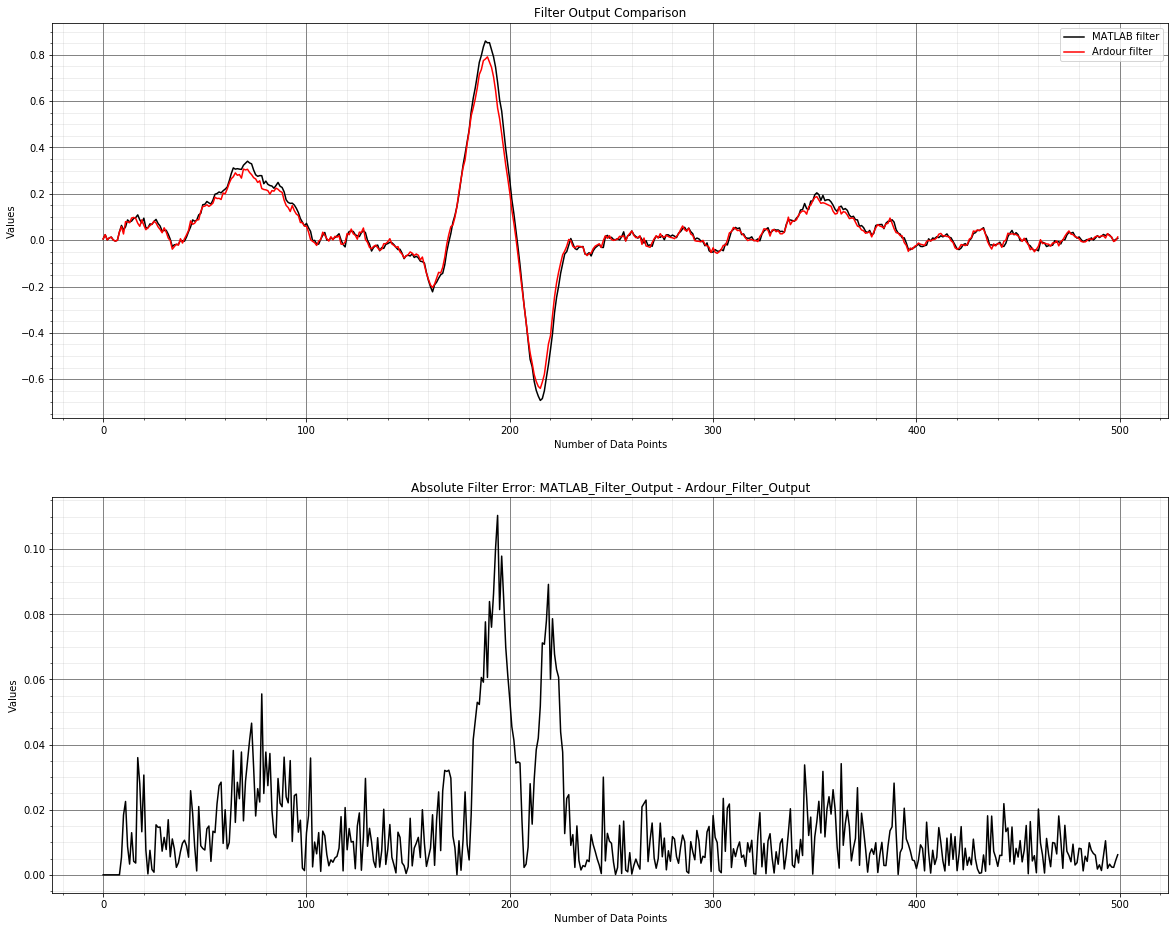

In [15]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filter, color='black', label ='MATLAB filter')
ax0.plot(df_matlab_results.index, y_filterArdour, color='red', label ='Ardour filter')
ax1.plot(df_matlab_results.index, filter_error_abs, color='black', label ='Filter Error')

ax0.set_title('Filter Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute Filter Error: MATLAB_Filter_Output - Ardour_Filter_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

## Ardour "filtfilt" Function (conventional filter with phase-distortion)

In [16]:
def filtfiltArdour(filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Variable initilization and preprocessing
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    u = input_signal            # input signal
    length = input_signal_len   # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))     # output signal; initialize with zeros
    
    filtACoeffs = filt_ACoeffs  # filter numerator coefficients
    filtBCoeffs = filt_BCoeffs  # filter denominator coefficients

    na = len(filtACoeffs)       # number of filter feedback coefficients (A)
    nb = len(filtBCoeffs)       # number of filter feedforward coefficients (B)
    nFilt = max(na,nb)          # max. number of given filter coefficients 
    filtOrd = nFilt - 1         # filter order
    nFact = 3*( nFilt - 1)    # length of edge transients ( 3 times filter order)
    nExt = length + 2 * nFact   # padding before and after signal
    
    nfilt = max(na,nb)          # 
    nfact = max(1,3*(nfilt-1))  # length of edge transients
    
    sample0 = 2*u[0]            # used for edge transfer reflection
    sampleN = 2*u[length-1]     # used for edge transfer reflection
    index = 0;                  # index variable for loops
    filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
    filtScratchOut = np.zeros((nExt,)) # function intern output sequence
    
    # zero pad shorter coeff arrays as needed
    if (nb < nFilt):
        filtBCoeffs = np.zeros((nFilt,))
    elif (na < nFilt):
        filtACoeffs = np.zeros((nFilt,))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Edge Transfer Reflection
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   starting edge transfer reflection
    for i in range(nFact, 0, -1):
        filtScratchIn[index] = sample0 - u[i]
        index = index + 1
        
    #   ending edge transfer reflection
    index = 0;
    for i in range(0, nFact):
        filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
        index = index + 1
        
    # (normal/unedited) raw signal inbetween edge transfer padding
    for i in range(0, length):
        filtScratchIn[i + nFact] = u[i]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 1st filtering (forward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                            filt_ACoeffs = filtACoeffs, 
                            filt_BCoeffs = filtBCoeffs, 
                            input_signal = filtScratchIn, 
                            input_signal_len = nExt)    
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 2nd filtering (backward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   reverse the filtered signal:
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    #   filter the reversed signal again (backward filtering)
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                        filt_ACoeffs = filtACoeffs, 
                        filt_BCoeffs = filtBCoeffs, 
                        input_signal = filtScratchIn, 
                        input_signal_len = nExt)
    
    #   reverse the reversed signal again to get the normal signal
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Remove Edge Transients padding for Output Signal
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range(0, length):
        y[i] = filtScratchIn[i + nFact]
        
    return y

In [17]:
y_filtfiltArdour = filtfiltArdour(
                            filt_ACoeffs = filt_A_coeffs, 
                            filt_BCoeffs = filt_B_coeffs, 
                            input_signal = df_wform_noisy, 
                            input_signal_len = 500)  

# calculate error between MATLAB filtfilt function and Ardour filtfilt function
filtfilt_error = np.abs(df_matlab_filtfilt - y_filtfiltArdour)

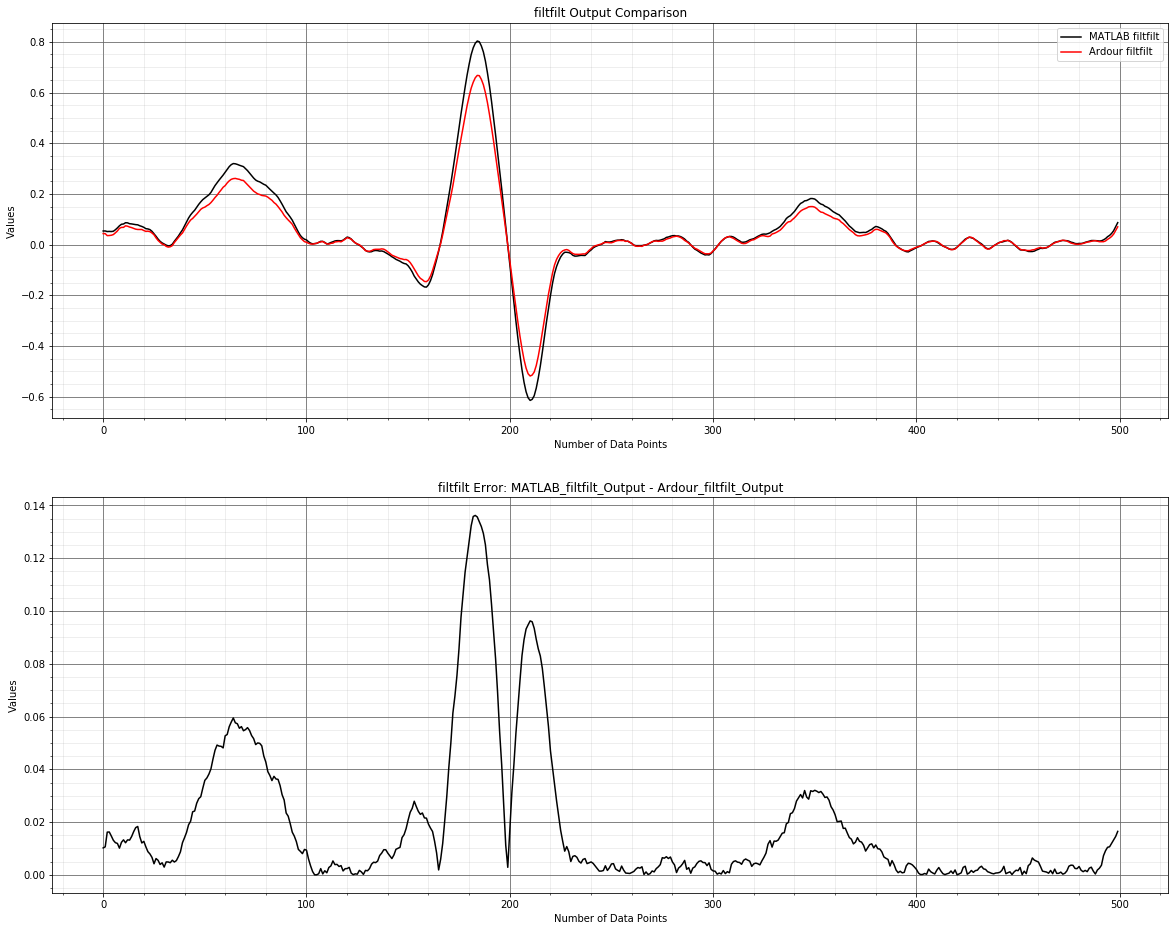

In [18]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filtfilt, color='black', label ='MATLAB filtfilt')
ax0.plot(df_matlab_results.index, y_filtfiltArdour, color='red', label ='Ardour filtfilt')
ax1.plot(df_matlab_results.index, filtfilt_error, color='black', label ='filtfilt error')

ax0.set_title('filtfilt Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('filtfilt Error: MATLAB_filtfilt_Output - Ardour_filtfilt_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# Function Tests

### isolated test of: Edge Transformation Reflection (used in filtfilt)

In [ ]:
# variables
u = df_wform_noisy           # input signal
length = len(df_wform_noisy) # length of input signal
y = np.zeros((length,))      # output signal

filt_ord = 12               # filter order
filt_ACoeffs = df_den_filt  # filter A coeffs
filt_BCoeffs = df_num_filt  # filter B coeffs

nFilt = filt_ord + 1
nFact = 3 * ( nFilt - 1)    # 3 times the filter order for padding
nExt = length + 2 * nFact   # length of padded signal (padding before and after raw signal: "nFact + length + nFact")

filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
filtScratchOut = np.zeros((nExt,)) # fuction intern output sequence

# edge transformation reflection
sample0 = 2 * u[0]          # two times the amplitude of first signal value 
sampleN = 2 * u[length-1]   # two times the amplitude of last signal value

In [ ]:
# Edge Transformation of start transient of signal
# - index: from [0]  to  [3*filt_ord-1]
index = 0;
for i in range(nFact, 0, -1):
    filtScratchIn[index] = sample0 - u[i]
    
    # print the calculation for control purposes
    print('filtScratchIn[',index,'] = 2 * u[ 0 ] - u[',i,']')
    index = index + 1   

In [ ]:
# write raw signal between edge transformation areas
# - index: from [3*filt_ord]  to  [inputSignalLength-1+3*filt_ord]
for i in range(0, length):
    filtScratchIn[i + nFact] = u[i]
    print('filtScratchIn[',i + nFact,'] = u[',i,']')
    

In [ ]:
# Edge Transformation of end transient of signal
# - index: from [inputSignalLength+3*filt_ord]  to  [inputSignalLength-1 +2*(3*filt_ord)]
index = 0;   
for i in range(0, nFact):
    filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
    print('filtScratchIn[',(nExt - nFact) + index ,'] = 2 * u[ 499 ] - u[',(length - 2) - i,']')
    index = index + 1

In [ ]:
# pad raw signal with zeros (needed for comparison plot)
index_plot = np.zeros((nExt,))
df_wform_noisy_comp =  np.zeros((nExt,))
counter = 0

for i in range(0, nExt):
    index_plot[i] = i
    
for i in range(nFact,nFact+500):
    df_wform_noisy_comp[i] = df_wform_noisy[counter]
    counter = counter + 1

In [ ]:
# plot comparison
fig, ax0 = plt.subplots(1, figsize=(20,12))

ax0.plot(index_plot, filtScratchIn, color='red', label ='filtScratchIn')
ax0.plot(index_plot, df_wform_noisy_comp, color='black', label ='raw input signal with zero padding')
ax0.vlines(x=nFact, ymin=min(filtScratchIn), ymax=max(filtScratchIn), color='black', linestyles='dashed')
ax0.vlines(x=length+nFact, ymin=min(filtScratchIn), ymax=max(filtScratchIn), color='black', linestyles='dashed') 

ax0.set_title('filter comparison')
ax0.set_xlabel('number of data points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


### isolated test of: Signal Reversion (used in filtfilt)

In [ ]:
input_array = [0,1,2,3,4,5,6,7,8,9]
input_array_rev = np.zeros((len(input_array),))

for i in range(0, len(input_array)):
    input_array_rev[i] = input_array[ len(input_array) -i -1 ]
    
print(input_array)
print(input_array_rev)

# Notes

In [ ]:
na = len(df_den_filt)
nb = len(df_den_filt)
nfilt = max(na,nb)          # 
nfact = max(1,3*(nfilt-1))  # length of edge transients

# zero pad shorter coeff arrays as needed
if (nb < nfilt):
    b = np.zeros((nfilt,))
#    b = []
#    for i in range(0, nb):
#        b[i] = df_den_filt[i]
#    for i in range(nb,nfilt):
#        b[i] = 0
elif (na < nfilt):
    a = np.zeros((nfilt,))
#    a = []
#    for i in range(0, na):
#        a[i] = df_num_filt[i]
#    for i in range(nb,nfilt):
#        a[i] = 0